## 1. Nhập các thư viện cần thiết
Trong phần này, chúng ta nhập tất cả các thư viện cần thiết cho xử lý dữ liệu, xử lý hình ảnh, trực quan hóa và xây dựng mô hình.

In [ ]:
import os

import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision.models as models
from torchvision.io import read_image
from torchvision import transforms

from PIL import Image

from matplotlib import pyplot as plt

import kagglehub

## 2. Tải xuống và chuẩn bị dữ liệu
Sử dụng KaggleHub để tải dữ liệu và chuẩn bị đường dẫn hình ảnh cùng với nhãn tương ứng.

In [ ]:
path = kagglehub.dataset_download("asdasdasasdas/garbage-classification")
path_to_dataset = path + '/Garbage classification/Garbage classification'
print("Path to dataset files:", path_to_dataset)

100%|██████████| 82.0M/82.0M [00:01<00:00, 56.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/asdasdasasdas/garbage-classification/versions/2/Garbage classification/Garbage classification


In [ ]:
classes_list = ['glass', 'metal', 'plastic', 'cardboard', 'paper', 'trash']
img_paths = []
labels = []
for class_name in classes_list:
    class_path = os.path.join(path_to_dataset, class_name)
    for img in os.listdir(class_path):
        img_path = os.path.join(class_path, img)
        img_paths.append(img_path)
        labels.append(class_name)

df = pd.DataFrame({
    'img_path':img_paths,
    'label':labels
})

df = df.sample(frac=1, random_state=0).reset_index(drop=True)

df.head()

,img_path,label
0,/root/.cache/kagglehub/datasets/asdasdasasdas/...,glass
1,/root/.cache/kagglehub/datasets/asdasdasasdas/...,paper
2,/root/.cache/kagglehub/datasets/asdasdasasdas/...,paper
3,/root/.cache/kagglehub/datasets/asdasdasasdas/...,plastic
4,/root/.cache/kagglehub/datasets/asdasdasasdas/...,paper


## 3. Trực quan hóa dữ liệu
Trực quan hóa phân bố các lớp hình ảnh trong tập dữ liệu.

Text(0.5, 0, 'Count')

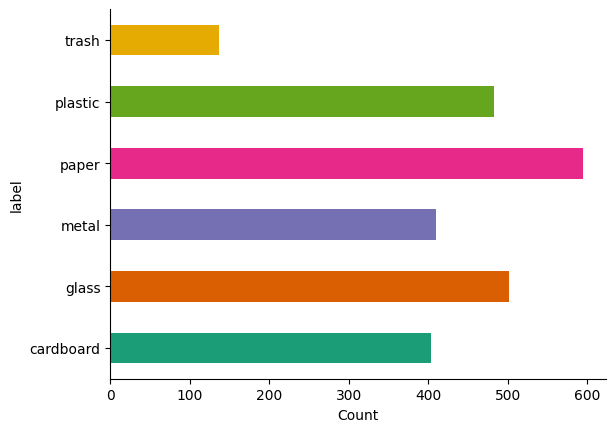

In [ ]:
df.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.xlabel('Count')

## 4. Tạo ánh xạ nhãn


In [ ]:
index_to_label = {index: label for index, label in enumerate(classes_list)}
label_to_index = {label: index for index, label in enumerate(classes_list)}

print("Index to Label Mapping:", index_to_label)
print("Label to Index Mapping:", label_to_index)

Index to Label Mapping: {0: 'glass', 1: 'metal', 2: 'plastic', 3: 'cardboard', 4: 'paper', 5: 'trash'}
Label to Index Mapping: {'glass': 0, 'metal': 1, 'plastic': 2, 'cardboard': 3, 'paper': 4, 'trash': 5}


In [ ]:
df['label_index'] = df['label'].map(label_to_index)

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [ ]:
df_train.head()

,img_path,label,label_index
0,/root/.cache/kagglehub/datasets/asdasdasasdas/...,cardboard,3
1,/root/.cache/kagglehub/datasets/asdasdasasdas/...,cardboard,3
2,/root/.cache/kagglehub/datasets/asdasdasasdas/...,trash,5
3,/root/.cache/kagglehub/datasets/asdasdasasdas/...,cardboard,3
4,/root/.cache/kagglehub/datasets/asdasdasasdas/...,glass,0


## 5. Tạo class Dataset tùy chỉnh

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.img_labels = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_labels.iloc[idx]['img_path']
        image = read_image(img_path).float() / 255.0
        label = self.img_labels.iloc[idx]['label_index']
        if self.transform:
            image = self.transform(image)
        return image, label

## 6. Áp dụng biến đổi dữ liệu và tạo DataLoader

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = ImageDataset(df_train, transform=transform)
test_dataset = ImageDataset(df_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Training samples: {len(train_dataset)}, Testing samples: {len(test_dataset)}")

Training samples: 2021, Testing samples: 506


## 7. Trực quan hóa hình ảnh mẫu

Hiển thị một vài hình ảnh mẫu từ tập dữ liệu.

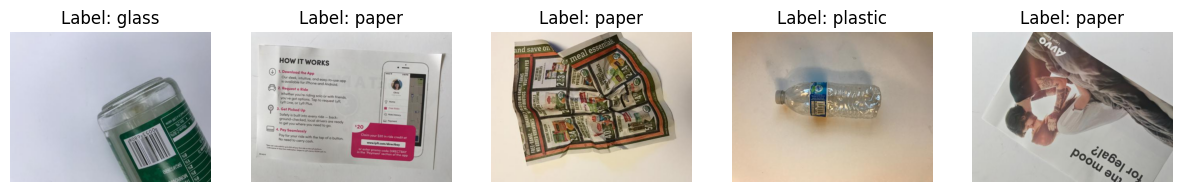

In [ ]:
def visualize_sample(dataset, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        image, label = dataset[i]
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image.permute(1, 2, 0))
        plt.title(f"Label: {index_to_label[label]}")
        plt.axis('off')
    plt.show()

org_dataset = ImageDataset(df)
visualize_sample(org_dataset)

## 8. Xây dựng mô hình ResNet tùy chỉnh

Xây dựng mô hình ResNet-18 tùy chỉnh với các thay đổi phù hợp với tác vụ phân loại của chúng ta.

In [ ]:
class CustomResNet18(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet18, self).__init__()

        self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.dropout = nn.Dropout(0.1)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.bn1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return nn.Softmax(dim=1)(x)

## 9. Huấn luyện và đánh giá mô hình


Định nghĩa các vòng lặp huấn luyện (training), đánh giá (validation) và theo dõi hiệu suất mô hình qua các epoch.

In [ ]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10, device=None):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_val_acc = 0.0
    best_model_wts = None

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0

        # Training
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += torch.sum(preds == labels.data)

        train_loss /= len(train_loader.dataset)
        train_accuracy = train_correct.double() / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels.data)

        val_loss /= len(test_loader.dataset)
        val_accuracy = val_correct.double() / len(test_loader.dataset)

        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_model_wts = model.state_dict()

        # Store history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_accuracy.item())
        history['val_acc'].append(val_accuracy.item())

        print(f"Epoch {epoch+1}/{num_epochs} -> Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    # Load the best model weights
    model.load_state_dict(best_model_wts)

    return model, history

Xây dựng hàm vẽ biểu đồ trực quan hóa lịch sử huấn luyện của mô hình, bao gồm mất mát (loss) và độ chính xác (accuracy) trong suốt quá trình huấn luyện và đánh giá.

In [ ]:
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Val Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

Tiến hành huấn luyện mô hình

In [ ]:
model = CustomResNet18(num_classes=len(classes_list))

for param in model.resnet.parameters():
    param.requires_grad = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model, history = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10, device=device)

torch.save(model.state_dict(), 'custom_resnet_garbage.pth')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 93.1MB/s]


Epoch 1/10 -> Train Loss: 1.5370, Train Acc: 0.6457, Val Loss: 1.4016, Val Acc: 0.7233
Epoch 2/10 -> Train Loss: 1.3299, Train Acc: 0.7892, Val Loss: 1.3328, Val Acc: 0.7589
Epoch 3/10 -> Train Loss: 1.2698, Train Acc: 0.8288, Val Loss: 1.2946, Val Acc: 0.8024
Epoch 4/10 -> Train Loss: 1.2309, Train Acc: 0.8590, Val Loss: 1.2872, Val Acc: 0.7885
Epoch 5/10 -> Train Loss: 1.2022, Train Acc: 0.8817, Val Loss: 1.2655, Val Acc: 0.8024
Epoch 6/10 -> Train Loss: 1.1808, Train Acc: 0.9030, Val Loss: 1.2714, Val Acc: 0.7925
Epoch 7/10 -> Train Loss: 1.1696, Train Acc: 0.9114, Val Loss: 1.2811, Val Acc: 0.7846
Epoch 8/10 -> Train Loss: 1.1523, Train Acc: 0.9193, Val Loss: 1.2572, Val Acc: 0.8083
Epoch 9/10 -> Train Loss: 1.1430, Train Acc: 0.9297, Val Loss: 1.2755, Val Acc: 0.7806
Epoch 10/10 -> Train Loss: 1.1387, Train Acc: 0.9337, Val Loss: 1.2447, Val Acc: 0.8182


Trực quan hóa lịch sử  huấn luyện

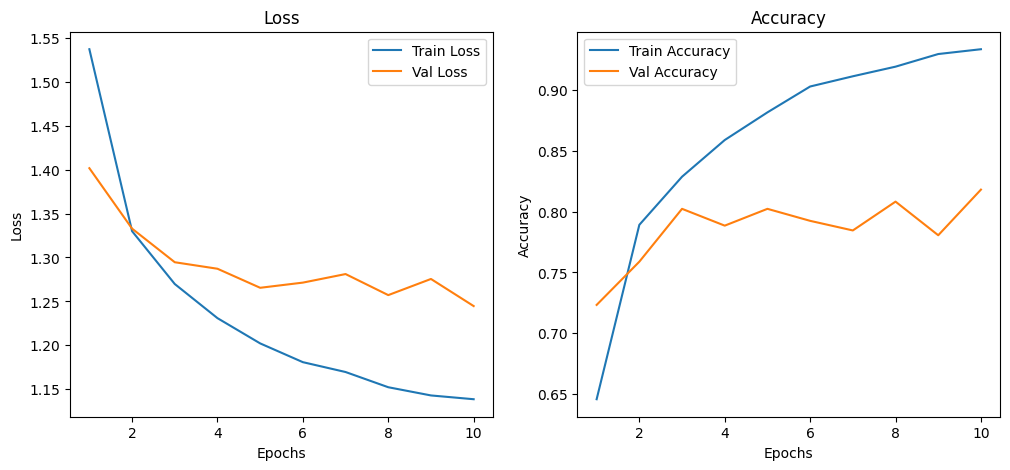

In [ ]:
plot_training_history(history)

## 10. Trực quan hóa dự đoán

In [ ]:
def visualize_images_with_predictions(image_paths, true_labels, model, index_to_label, device, num_samples=5):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        image_path = image_paths[i]
        true_label = true_labels[i]

        image_org = Image.open(image_path).convert('RGB')
        image = transform(image_org).unsqueeze(0).to(device)

        model.eval()
        with torch.no_grad():
            outputs = model(image)
            percent, predicted = torch.max(outputs, 1)

        predicted_label = index_to_label[predicted.item()]
        predicted_percent = percent.item() * 100

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image_org)
        plt.title(f"True: {true_label}\nPred: {predicted_label}, {predicted_percent:.2f}%")
        plt.axis('off')
    plt.savefig('fig_4.pdf')
    plt.show()

Hiển thị dự đoán mẫu từ mô hình đã được huấn luyện.

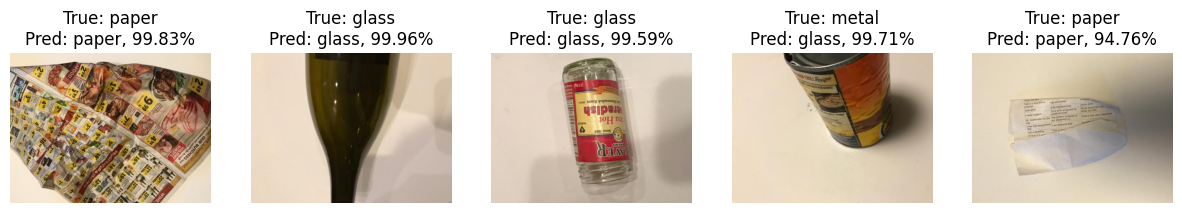

In [ ]:
image_paths = df_test['img_path'].iloc[:5].tolist()
true_labels = df_test['label'].iloc[:5].tolist()
visualize_images_with_predictions(image_paths, true_labels, model, index_to_label, device, num_samples=5)